<a href="https://colab.research.google.com/github/kshitijaw2228/Facial-expression-recognizer/blob/main/Facial_Expression_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2021-07-21 08:45:12--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/si11cws2pyho1bp/archive.zip [following]
--2021-07-21 08:45:12--  https://www.dropbox.com/s/raw/si11cws2pyho1bp/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce7e7befb6b028c7594354a63f9.dl.dropboxusercontent.com/cd/0/inline/BSuXlJcPG5c549v70zaiNHWOjU4IesBMeVN92UlNap2_AhFeL5_905lBgtv4iRPM_Wg_KJ8VStdOp_TfwHRxYrCpI2C36WMEdoVlqp-Ei1OFBMBbWlBp0QDx6e-BN1gCOI-3x0h1KYx_4Y9YSAMXsfBV/file# [following]
--2021-07-21 08:45:14--  https://uce7e7befb6b028c7594354a63f9.dl.dropboxusercontent.com/cd/0/inline/BSuXlJcPG5c549v70zaiNHWOjU4IesBMeVN92UlNap2_AhFeL5_905lBgtv4iRPM_Wg_KJ8VStdOp_TfwHRxYrCpI2C36

In [3]:
!unzip -q "/content/archive.zip"

In [4]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [5]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [6]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/neutral/Training_19037384.jpg',
 '/content/train/neutral/Training_87232222.jpg',
 '/content/train/neutral/Training_58773350.jpg',
 '/content/train/neutral/Training_5181007.jpg',
 '/content/train/neutral/Training_88309113.jpg',
 '/content/train/neutral/Training_46648975.jpg',
 '/content/train/neutral/Training_3223359.jpg',
 '/content/train/neutral/Training_31153578.jpg',
 '/content/train/neutral/Training_23146617.jpg',
 '/content/train/neutral/Training_73762189.jpg']

In [7]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral']

In [8]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [9]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [10]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [11]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8076539, 1: 16.662577, 2: 1.7567917, 3: 1.0, 4: 1.4813199, 5: 1.4878116, 6: 2.303647}


In [12]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [13]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [14]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [15]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 341 ms, sys: 1.3 ms, total: 343 ms
Wall time: 388 ms
(32, 96, 96, 3)
(32, 7)


happy


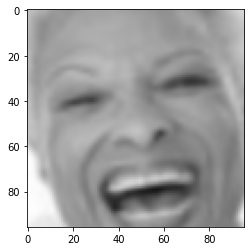

In [16]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [17]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 20.6 ms, sys: 1.81 ms, total: 22.4 ms
Wall time: 26.1 ms
(32, 96, 96, 3)
(32, 7)


neutral


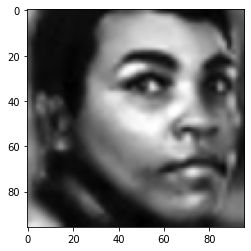

In [18]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [19]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.summary()

31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 7,882,249
Non-trainable params: 67,575
_________________________________________________________________


In [20]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [21]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/12
672/672 [==============================] - 140s 144ms/step - loss: 2.8796 - accuracy: 0.3865 - precision: 0.6405 - recall: 0.1686 - val_loss: 1.4906 - val_accuracy: 0.4697 - val_precision: 0.6064 - val_recall: 0.3336
Epoch 2/12
672/672 [==============================] - 98s 143ms/step - loss: 2.4225 - accuracy: 0.4817 - precision: 0.6876 - recall: 0.2757 - val_loss: 1.4422 - val_accuracy: 0.4573 - val_precision: 0.5727 - val_recall: 0.3161
Epoch 3/12
672/672 [==============================] - 94s 141ms/step - loss: 2.2608 - accuracy: 0.5161 - precision: 0.6978 - recall: 0.3157 - val_loss: 1.2337 - val_accuracy: 0.5402 - val_precision: 0.7093 - val_recall: 0.3156
Epoch 4/12
672/672 [==============================] - 97s 144ms/step - loss: 2.1765 - accuracy: 0.5342 - precision: 0.7114 - recall: 0.3407 - val_loss: 1.2586 - val_accuracy: 0.533

In [22]:
model.layers[0].trainable = False

In [23]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               180352    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
_________________________________________________________________


In [27]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/8
672/672 [==============================] - 96s 142ms/step - loss: 1.3042 - accuracy: 0.7042 - precision: 0.7888 - recall: 0.6108 - val_loss: 1.1443 - val_accuracy: 0.6165 - val_precision: 0.6702 - val_recall: 0.5451

Epoch 00001: val_loss did not improve from 1.03749
Epoch 2/8
672/672 [==============================] - 96s 143ms/step - loss: 1.3019 - accuracy: 0.7005 - precision: 0.7892 - recall: 0.6106 - val_loss: 1.1601 - val_accuracy: 0.6143 - val_precision: 0.6612 - val_recall: 0.5625

Epoch 00002: val_loss did not improve from 1.03749
Epoch 3/8
672/672 [==============================] - 95s 141ms/step - loss: 1.2297 - accuracy: 0.7190 - precision: 0.7956 - recall: 0.6358 - val_loss: 1.1596 - val_accuracy: 0.6148 - val_precision: 0.6695 - val_recall: 0.5573

Epoch 00003: val_loss did not improve from 1.03749
Epoch 4/8
672/672 [==============================] - 95s 141ms/step - loss: 1.2541 - accuracy: 0.7164 - precision: 0.7917 - recall: 0.6284 - val_loss: 1.0924 - val_ac

In [28]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [29]:
model.load_weights("best_weights.h5")

In [30]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [31]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


neutral


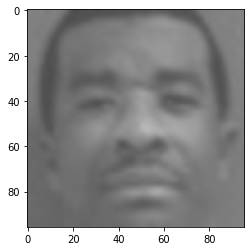

In [32]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [33]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

225/225 [==============================] - 10s 30ms/step - loss: 1.0561 - accuracy: 0.6197 - precision: 0.6938 - recall: 0.5410
 Testing Acc :  0.6196712255477905
 Testing Precision  0.6937645077705383
 Testing Recall  0.5409584641456604


In [34]:
# Save Model
model.save("FacialExpressionModel.h5")

In [35]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [36]:
save_object(Le, "LabelEncoder")